## On change la loss function --> (multinomial) CrossEntropy loss

## output = multinomial sample

## Passage à une architecture convolutionnelle

Ajouts/modifs :
  * simplification de l'architecture (seule l'image blanchie est en entrée)
  * dans le roll : supression des régions hors image (np.pad) 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time


## Torch libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch.utils.data as data

# Generating the data base:
## First, we download the original images and fixation maps.
This requires having internet connexion

Size of the Folder 'ALLSTIMULI' : 225 Mo

Size of the Folder 'ALLFIXATIONMAPS' : 23,6 Mo

In [3]:
if not(os.path.exists('ALLSTIMULI')):
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen
    img='http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLSTIMULI.zip'
    resp = urlopen(img)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall()
    print('Download of ALLSTIMULI complete')
if not(os.path.exists('ALLFIXATIONMAPS')):
    from io import BytesIO
    from zipfile import ZipFile
    from urllib.request import urlopen
    img='http://people.csail.mit.edu/tjudd/WherePeopleLook/ALLFIXATIONMAPS.zip'
    resp = urlopen(img)
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall()
    print('Download of ALLFIXATIONMAPS complete')

## Then, we generate the global images data base.
The images and fixations are 1003 grey images in numpy files of size 256x256, with memory space of 65 Ko each.

In total, we have:

GLOBAL_IMAGES :  59,7 Mo

GLOBAL_FIXATIONMAPS :    59,7 Mo

GLOBAL_IMAGES_TEST :        3,06 Mo

GLOBAL_FIXATIONMAPS_TEST : 3,06 Mo

In total we have 125.72 Mo

In [4]:
#size used for downsizing images
size=256

test_sample_ratio=5/100
#folder names
imdir_org,fixdir_org='ALLSTIMULI/ALLSTIMULI','ALLFIXATIONMAPS/ALLFIXATIONMAPS'
#imdir_new,fixdir_new='GLOBAL_IMAGES','GLOBAL_FIXATIONMAPS'
#imdir_test,fixdir_test='GLOBAL_IMAGES_TEST','GLOBAL_FIXATIONMAPS_TEST'
#creating empty folders:

imdir, fixdir = 'GLOBAL_IMAGES_ALL_PLAIN','GLOBAL_FIXATIONMAPS_ALL_PLAIN'
imdir_white, fixdir_white = 'GLOBAL_IMAGES_ALL_WHITE','GLOBAL_FIXATIONMAPS_ALL_WHITE'



In [5]:
for directory in [imdir,fixdir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
#image and fixation names
import fnmatch #fnmatch to keep only image files
image_files =fnmatch.filter(os.listdir(imdir_org), '*.jpeg')
fixation_files = []
for image_name in image_files:
    fixation_files.append(image_name[:-5] +'_fixMap.jpg')
#number of images : 1003
N=len(image_files)
#N_test=int(l*test_sample_ratio)
#N_train=l-N_test
print('Total number of images :', N)
#import SLIP for whitening and PIL for resizing
import SLIP
import PIL
#default parameters for the whitening
im = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

Total number of images : 1003


In [6]:
#print(os.listdir(imdir_org))

In [7]:
if False : #not os.path.exists(imdir):
    for idx in range(N):
        if idx%100==0:
            print('Avancement=',int(idx/N*100),'%')
        #check if file exists
        '''if idx<=N_train:
            img_dir,fix_dir=imdir_new,fixdir_new
        else:
            img_dir,fix_dir=imdir_test,fixdir_test'''
        #if not (os.path.exists(os.path.join(img_dir,image_files[idx][:-5])) and os.path.exists(os.path.join(fix_dir,fixation_files[idx][:-4])) ):
        #loading images and fixations
        img_name = os.path.join(imdir_org,image_files[idx])
        fix_name = os.path.join(fixdir_org,fixation_files[idx])
        image = PIL.Image.open(img_name)
        fixation=PIL.Image.open(fix_name)
        #resizing
        image=image.resize((size,size))
        fixation=fixation.resize((size,size))
        #saving in a temporary file:
        image.save('temp_image.jpeg')
        #whitening
        image=im.imread('temp_image.jpeg')
            ##whitening only works for pair shape
        raws=image.shape[0]
        columns=image.shape[1]
        if raws%2!=0:
            image=image[:-1,:]
            fixation=fixation[:-1,:]
        if columns%2!=0:
            image=image[:,:-1]
            fixation=fixation[:,:-1]
        raws=image.shape[0]
        columns=image.shape[1]
        im.set_size((raws,columns))
            ##apply whitening
        image = im.whitening(image)
        image = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype('uint8')
        #saving
        '''if idx<=N_train:
            img_dir,fix_dir=imdir_new,fixdir_new
        else:
            img_dir,fix_dir=imdir_test,fixdir_test'''
        np.save(os.path.join(imdir,image_files[idx][:-5]), np.array(image,dtype=np.uint8))
        np.save(os.path.join(fixdir,fixation_files[idx][:-4]), np.array(fixation,dtype=np.uint8))
    print('Avancement= 100 %')
    print('COMPLETE : GLOBAL IMAGES AND FIXATION MAPS GENERATED SUCCESSFULLY.')

### Tests

In [8]:
i = 0

'''image_ref_dir = imdir_org
image_ref_names=os.listdir(image_ref_dir)
image_ref=np.load(os.path.join(image_ref_dir,image_ref_names[i]))

fix_ref_dir = fixdir_org
fix_ref_names=os.listdir(fix_ref_dir)
fix_ref=np.load(os.path.join(fix_ref_dir,fix_ref_names[i]))'''

image_dir = imdir #imdir_new
image_names=os.listdir(image_dir)
image=np.load(os.path.join(image_dir,image_names[i]))

image_dir_white = imdir_white #imdir_new
image_white_names=os.listdir(image_dir_white)
image_white=np.load(os.path.join(image_dir_white,image_names[i]))

fix_dir = fixdir #fixdir_new
fix_names=os.listdir(fix_dir)
fix=np.load(os.path.join(fix_dir,fix_names[i]))


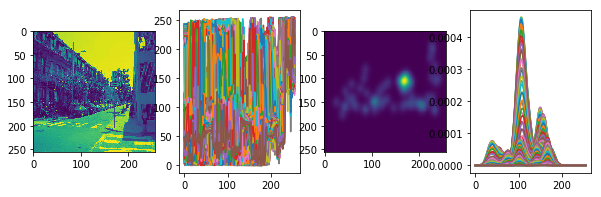

In [9]:
plt.figure(figsize = (10,3))
'''plt.subplot(141)
plt.imshow(image_ref)
plt.subplot(142)
_ = plt.plot(fix_ref)'''
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
_ = plt.plot(image)
plt.subplot(143)
plt.imshow(fix)
plt.subplot(144)
_ = plt.plot(fix/sum(fix.flatten()))

(array([154]), array([175]))
175


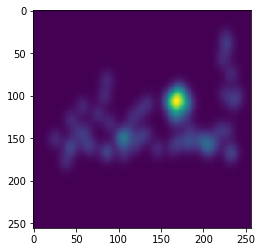

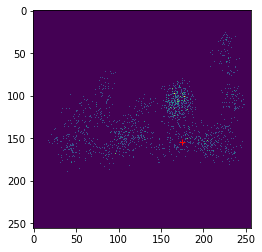

In [10]:
plt.imshow(fix)
m = fix/sum(fix.flatten())
m = m.flatten()

'''for i in range(20):
    print(np.where(np.random.multinomial(1, m) == 1)[0][0])'''

m_mult = np.random.multinomial(2000, m)
plt.figure()
plt.imshow(m_mult.reshape(256, 256))

m_mult = np.random.multinomial(1, m).reshape(256, 256)
print(np.where(m_mult == 1))
coord = np.where(m_mult == 1)
plt.plot(coord[1], coord[0], 'r+')
print(coord[1][0])
    

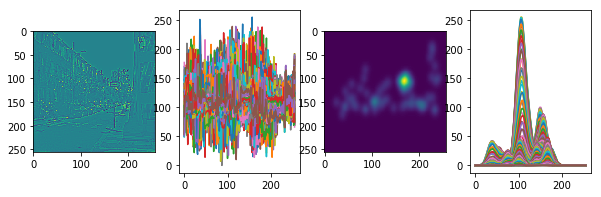

In [11]:
plt.figure(figsize = (10,3))
'''plt.subplot(141)
plt.imshow(image_ref)
plt.subplot(142)
_ = plt.plot(fix_ref)'''
plt.subplot(141)
plt.imshow(image_white)
plt.subplot(142)
_ = plt.plot(image_white)
plt.subplot(143)
plt.imshow(fix)
plt.subplot(144)
_ = plt.plot(fix)

## Vision stuff

In [12]:
from LogGabor import LogGabor

In [13]:
N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 24, 16, 2, 256, 256, 1.21 #1.41 #1.25 #
#N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho = 6, 12, 8, 2, 256, 256, 1.41
verbose = 1
OFFSET_STD = 15
OFFSET_MAX = 30

## Pierre's stuff

### Encoding : N_theta x N_azimuth x N_eccentricity x N_phase  2D filters (to be applied on N_X x N_Y pixels)

#### Préparer l'apprentissage et les fonctions nécessaires au fonctionnement du script

In [14]:
def vectorization(N_theta=N_theta, N_azimuth=N_azimuth, N_eccentricity=N_eccentricity, N_phase=N_phase, \
                  N_X=N_X, N_Y=N_Y, rho=rho, ecc_max=1, B_sf=.4, B_theta=np.pi/N_theta/2):
    retina = np.zeros((N_theta, N_azimuth, N_eccentricity, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    # params = {'sf_0': .1, 'B_sf': lg.pe.B_sf,
    #           'theta': np.pi * 5 / 7., 'B_theta': lg.pe.B_theta}
    # phase = np.pi/4
    # edge = lg.normalize(lg.invert(lg.loggabor(
    #     N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

    for i_theta in range(N_theta):
        for i_azimuth in range(N_azimuth):
            for i_eccentricity in range(N_eccentricity):
                ecc = ecc_max * (1/rho)**(N_eccentricity - i_eccentricity)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc  # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * \
                    np.cos((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                y = N_Y/2 + r * \
                    np.sin((i_azimuth+(i_eccentricity % 2)*.5)*np.pi*2 / N_azimuth)
                for i_phase in range(N_phase):
                    params = {'sf_0': sf_0, 'B_sf': B_sf,
                              'theta': i_theta*np.pi/N_theta, 'B_theta': B_theta}
                    phase = i_phase * np.pi/2
                    # print(r, x, y, phase, params)

                    retina[i_theta, i_azimuth, i_eccentricity, i_phase, :] = lg.normalize(
                        lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()


    return retina

#### Full encoding

In [15]:
#del retina

In [16]:
FIC_NAME = 'retina_256_24_ecc_16.npy'
if not os.path.exists(FIC_NAME):
    retina = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho) #, ecc_max=1)
    np.save(FIC_NAME, retina)
else:
    retina = np.load(FIC_NAME)


In [17]:
print(retina.shape)

(6, 24, 16, 2, 65536)


In [18]:
retina_vector = retina.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(4608, 65536)


In [19]:
FIC_NAME = 'retina_inverse_256_24_ecc_16.npy'
if not os.path.exists(FIC_NAME):
    retina_inverse = np.linalg.pinv(retina_vector)
    np.save(FIC_NAME, retina_inverse)
else:
    retina_inverse = np.load(FIC_NAME)
print(retina_inverse.shape)

(65536, 4608)


#### Orientation invariant power encoding (colliculus??)

In [20]:
colliculus = (retina**2).sum(axis=(0, 3))
colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(24, 16, 65536)


In [21]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(384, 65536)


In [22]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

(65536, 384)


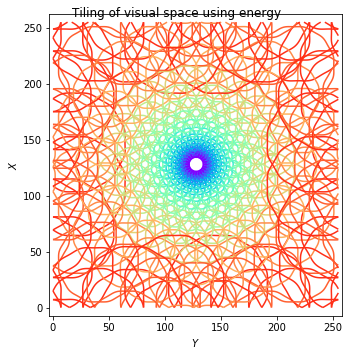

In [23]:
energy = colliculus ** 2
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

## Images dataset

In [24]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return int(value)

In [25]:
np.random.rand() > 0.5

True

In [41]:
#im = SLIP.Image(pe='https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py')

class Transform(object):
    """Rescale the image through LogGabors

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, test = False, tensor = False):
        #assert isinstance(output_size, (int, tuple))
        #self.output_size = output_size
        self.test = test
        self.tensor = tensor

    def __call__(self, sample):
        image, image_white, fixmap = sample['image'], sample['image_white'], sample['fixation']
        (nb_l, nb_col) = image.shape
        
        #i_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
        #j_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
        
        '''if np.random.rand() > 0.5:
            image_white = np.fliplr(image_white)
            image = np.fliplr(image)
            fixmap = np.fliplr(fixmap)'''
        
        m = fixmap/sum(fixmap.flatten())
        m = m.flatten()
        m_mult = np.random.multinomial(1, m).reshape(256, 256)
        coord = np.where(m_mult == 1)
        i_offset = 127 - coord[0][0]
        j_offset = 127 - coord[1][0]
        
        '''i_offset = 0
        j_offset = -50'''
        
        image_white = np.roll(image_white, i_offset, axis=0)
        image_white = np.roll(image_white, j_offset, axis=1)  
        mean_white = np.mean(image_white.flatten())
        std_white = np.std(image_white.flatten())
        
        image = np.roll(image, i_offset, axis=0)
        image = np.roll(image, j_offset, axis=1)
        mean_im = np.mean(image.flatten())
        std_im = np.std(image.flatten())
        
        fixmap = np.roll(fixmap, i_offset, axis=0)
        fixmap = np.roll(fixmap, j_offset, axis=1)    
        
        if i_offset > 0 :
            image_white[:i_offset, :] = mean_white + std_white * np.random.randn(i_offset, nb_col) #127
            image[:i_offset, :] = mean_im + std_im * np.random.randn(i_offset, nb_col) #127
            fixmap[:i_offset, :] = 0
        elif i_offset < 0:
            image_white[i_offset:, :] = mean_white + std_white * np.random.randn(-i_offset, nb_col) #127
            image[i_offset:, :] = mean_im + std_im * np.random.randn(-i_offset, nb_col) #127
            fixmap[i_offset:, :] = 0     
        
        if j_offset > 0 :
            image_white[:,:j_offset] = mean_white + std_white * np.random.randn(nb_l, j_offset) #127
            image[:,:j_offset] = mean_im + std_im * np.random.randn(nb_l, j_offset) #127
            fixmap[:,:j_offset] = 0
        elif j_offset < 0:
            image_white[:,j_offset:] = mean_white + std_white * np.random.randn(nb_l, -j_offset) 
            image[:,j_offset:] = mean_im + std_im * np.random.randn(nb_l, -j_offset) 
            fixmap[:,j_offset:] = 0
        
        image_white = (image_white - mean_white) / std_white
        image = (image - mean_im) / std_im
        
        '''plt.figure()    
        plt.imshow(image_white, cmap = 'gray')
        plt.figure()    
        plt.imshow(fixmap, cmap = 'gray')'''
        
        image_retina = retina_vector @ np.ravel(image_white)
        #image_retina /= np.std(image_retina)
        
        image_colliculus = colliculus_vector @ np.ravel(image)
        #image_colliculus -= np.mean(image_colliculus)
        #image_colliculus /= np.std(image_colliculus)
        
        fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)
        fixmap_colliculus = fixmap_colliculus/np.sum(fixmap_colliculus)
        
        if not self.test:
            m_coll = fixmap_colliculus/sum(fixmap_colliculus)
            m_coll_mult = np.random.multinomial(25, m_coll)
            #m_coll_mult[np.where(m_coll_mult > 1)] = 1
            m_coll_mult = np.array(m_coll_mult)/np.sum(m_coll_mult)
        
        if self.tensor:
            image_retina = image_retina.reshape(N_theta, N_azimuth, N_eccentricity, N_phase)
            slice1 = image_retina[N_theta - 1,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
            slice2 = image_retina[0,:,:,:].reshape(1,N_azimuth,N_eccentricity,N_phase)
            image_retina = np.concatenate ((slice1, image_retina, slice2), axis = 0)
            image_retina = np.transpose(image_retina,(3,0,1,2))
            image_colliculus = image_colliculus.reshape(1,N_azimuth, N_eccentricity)
            '''if not self.test:
                m_coll_mult = m_coll_mult.reshape(1, N_azimuth, N_eccentricity)
            else:
                fixmap_colliculus = fixmap_colliculus.reshape(N_azimuth, N_eccentricity)'''
                
        if self.test:
            return {'image': image_colliculus, 'image_white': image_retina, 'fixation': fixmap_colliculus}
        else:
            return {'image': image_colliculus, 'image_white': image_retina, 'fixation': m_coll_mult}   
        
        #r 

In [42]:
## test

In [43]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, image_white, fixmap = sample['image'], sample['image_white'], sample['fixation']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'image_white': torch.from_numpy(image_white),
                'fixation': torch.from_numpy(landmarks)}

In [44]:
class ImageDataset(data.Dataset):
    """image dataset."""

    def __init__(self, imdir, imdir_white, fixdir, transform=None, index = None):
        """
        Args:
            imdir (string): Path to the image folder
            fixdir (string): Path to the fixation maps folder
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imdir = imdir
        self.fixdir = fixdir
        self.imdir_white = imdir_white
        if index is None :
            print('OK')
            self.image_names=os.listdir(imdir)
            self.fix_names=os.listdir(fixdir)
        else:
            self.image_names=np.array(os.listdir(imdir))[index]
            self.fix_names=np.array(os.listdir(fixdir))[index]
        self.transform = transform # we do not use transforms
        #self.data_loader=data.DataLoader(self,batch_size=batch_size) : did not work
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image=np.load(os.path.join(self.imdir,self.image_names[idx]))
        image_white=np.load(os.path.join(self.imdir_white,self.image_names[idx]))
        fix_map=np.load(os.path.join(self.fixdir,self.fix_names[idx]))/255 # to transform between 0 and 1 (for the BCELoss to work)

        sample = {'image': image, 'image_white': image_white, 'fixation': fix_map}

        if self.transform:
            sample = self.transform(sample)
        
        return sample


### Tests

In [45]:
trans = Transform(tensor = False)
dataset = ImageDataset(image_dir,image_dir_white,fix_dir)

OK


In [46]:
i = 0
sample = dataset[i] #['image'], dataset[i]['fixation'] 

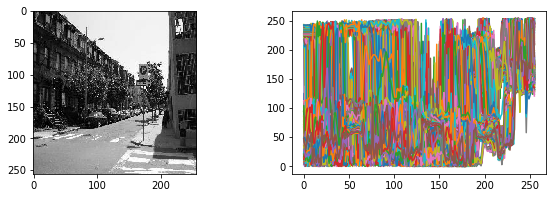

In [47]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(sample['image'], cmap = 'gray')
plt.subplot(122)
_ = plt.plot(sample['image'])

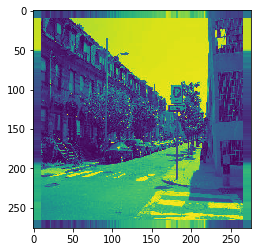

In [48]:
im = sample['image']
im2 = np.pad(im, ((10, 10), (10, 10)), 'median')
plt.imshow(im2)

-8 30
15


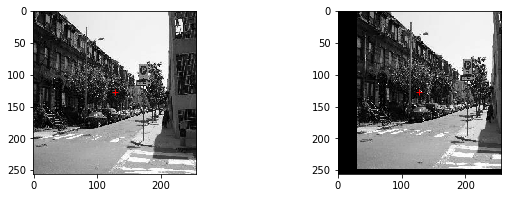

In [49]:
image_off = sample['image']
i_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
j_offset = minmax(np.random.randn() * OFFSET_STD, OFFSET_MAX)
print(i_offset, j_offset)
print(OFFSET_STD)
image_off = np.roll(image_off, i_offset, axis=0)
image_off = np.roll(image_off, j_offset, axis=1)    
if i_offset > 0 :
    image_off[:i_offset, :] = 0
elif i_offset < 0:
    image_off[i_offset:, :] = 0

if j_offset > 0 :
    image_off[:,:j_offset] = 0
elif j_offset < 0:
    image_off[:,j_offset:] = 0

plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(sample['image'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')
plt.subplot(122)
plt.imshow(image_off, cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

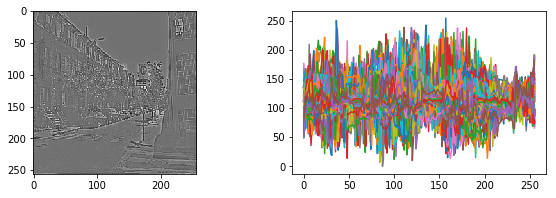

In [50]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(sample['image_white'], cmap = 'gray')
plt.subplot(122)
_ = plt.plot(sample['image_white'])

In [51]:
'''train = True
batch_size = 10
data_loader = torch.utils.data.DataLoader(dataset, train=train, download=True, batch_size=batch_size, shuffle=True)'''
dataloader = data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)

In [52]:
batch = next(iter(dataloader))

In [53]:
batch['image'].shape

torch.Size([10, 256, 256])

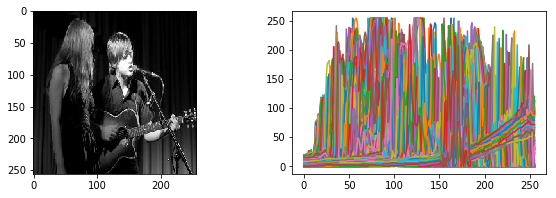

In [54]:
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.imshow(batch['image'][0,:,:], cmap = 'gray')
plt.subplot(122)
_ = plt.plot(batch['image'][0,:,:])

### Encoding test

(2, 6, 24, 16)
(6, 24, 16, 2)


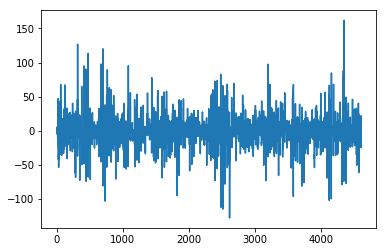

In [55]:
trans = Transform(tensor = True)
sample_retina = trans(sample) #retina_vector @ np.ravel(sample['image'])
sample_cut = sample_retina['image_white'][:,1:N_theta+1,:,:]
print(sample_cut.shape)
sample_cut = np.transpose(sample_cut, (1,2,3,0))
print(sample_cut.shape)
plt.figure()
plt.plot(sample_cut.reshape(N_azimuth * N_eccentricity * N_theta * N_phase))

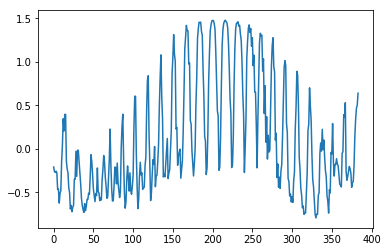

In [56]:
trans = Transform()
sample_retina = trans(sample) #retina_vector @ np.ravel(sample['image'])
plt.plot(sample_retina['image'].reshape(N_azimuth * N_eccentricity))

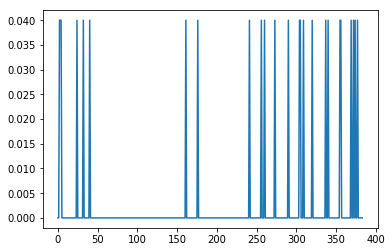

In [57]:
#data_colliculus = colliculus_vector @ np.ravel(sample['fixation'])
plt.plot(sample_retina['fixation'].reshape(N_azimuth * N_eccentricity))

In [58]:
### Polar plot

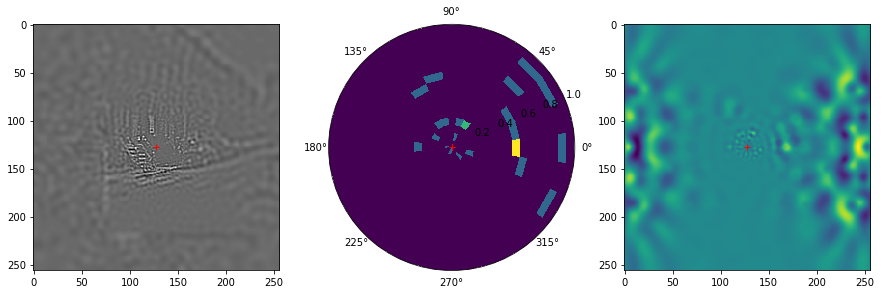

In [59]:
trans = Transform(test = False)
sample_retina = trans(sample)
delta = 1/N_azimuth
log_r, theta = np.meshgrid(np.linspace(0, 1, N_eccentricity + 1), np.linspace(-np.pi*(.5 + delta), np.pi*(1.5 - delta), N_azimuth + 1))
f = plt.figure(figsize = (15,5))

plt.subplot(131)
data_retina = sample_retina['image_white'].reshape(N_azimuth * N_eccentricity * N_theta * N_phase)
#data_retina = sample_cut.reshape(N_azimuth * N_eccentricity * N_theta * N_phase)
image_white = retina_inverse @ data_retina
#im = colliculus_inverse @ data_retina
plt.imshow(image_white.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

ax = f.add_subplot(132, projection='polar')
vec = sample_retina['fixation'].reshape(N_azimuth * N_eccentricity)
ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
plt.plot(0,0, 'r+')

ax = f.add_subplot(133)
plt.imshow((colliculus_inverse @ vec).reshape(N_X, N_Y) )#sample['fixation'])
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

In [60]:
colliculus_inverse @ vec

array([-0.0303974 , -0.10030533, -0.16808261, ...,  0.17414535,
        0.11035107,  0.04218922])

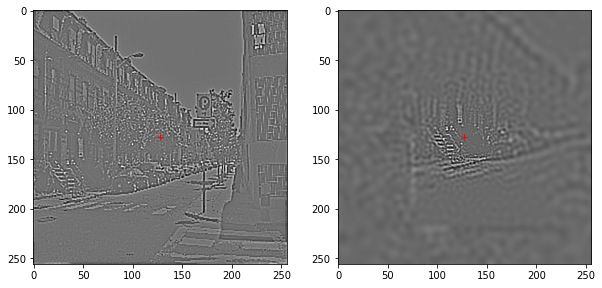

In [61]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(sample['image_white'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

plt.subplot(122)
data_retina = sample_retina['image_white'].reshape(N_azimuth * N_eccentricity * N_theta * N_phase)
image_white = retina_inverse @ data_retina
#im = colliculus_inverse @ data_retina
plt.imshow(image_white.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

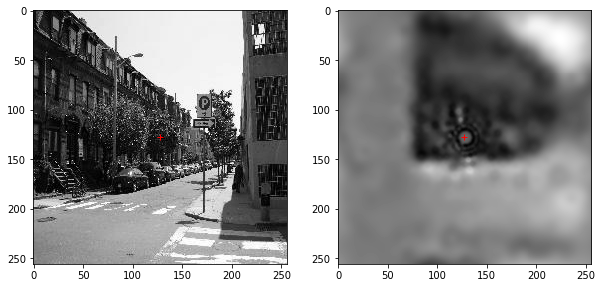

In [62]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(sample['image'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

plt.subplot(122)
data_retina = sample_retina['image'].reshape(N_azimuth * N_eccentricity)
image = colliculus_inverse @ data_retina
#im = colliculus_inverse @ data_retina
plt.imshow(image.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

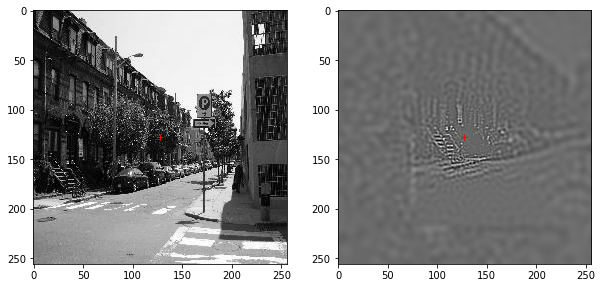

In [63]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(sample['image'], cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')

plt.subplot(122)
plt.imshow(10 * image_white.reshape(N_X, N_Y)+image.reshape(N_X, N_Y), cmap = 'gray')
plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')


In [64]:
if False:
    transform = Transform()
    batch_size = 100
    dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform)
    dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    batch = next(iter(dataloader))

In [65]:
if False :
    fixmap_avg = sum(batch['fixation'])/batch_size

    f = plt.figure(figsize = (15, 5))

    i = 3

    plt.subplot(131)
    #for i in range(10):
    plt.plot(batch['fixation'][i,:], 'g')
    plt.plot(batch['fixation'][i,:] - fixmap_avg)
    plt.plot(fixmap_avg,'r')

    ax = f.add_subplot(132, projection='polar')
    vec = batch['fixation'][i,:] 
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0, 'r+')

    ax = f.add_subplot(133, projection='polar')
    vec = batch['fixation'][i,:] - fixmap_avg
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0, 'r+')



#### Input vectors encoding

In [66]:
'''def image_fullfield(image):
    image_retina = retina_vector @ np.ravel(image)
    return image_retina'''

'def image_fullfield(image):\n    image_retina = retina_vector @ np.ravel(image)\n    return image_retina'

#### Output vectors (Accuracy/Saliency map) encoding

In [67]:
'''def fixmap_fullfield(fixmap):   
    fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)
    return fixmap_colliculus'''

'def fixmap_fullfield(fixmap):   \n    fixmap_colliculus = colliculus_vector @ np.ravel(fixmap)\n    return fixmap_colliculus'

In [68]:
'''def couples(image, fixmap): #, device):
    #data = data.to(device)
    v = image_fullfield(data)
    a = fixmap_fullfield(fixmap)
    return (v, a)'''

'def couples(image, fixmap): #, device):\n    #data = data.to(device)\n    v = image_fullfield(data)\n    a = fixmap_fullfield(fixmap)\n    return (v, a)'

#### Hyperparameters

In [69]:
minibatch_size = 25  # quantity of examples that'll be processed
lr = 1e-4 #0.05

n_hidden1_white = 2000 #800 #
n_hidden1 = 500 #200 #
n_hidden2 = 500 #50 #
n_hidden3 = 50  #10 #50
n_hidden4 = 500 #50

print('n_hidden1', n_hidden1, ' / n_hidden2', n_hidden2)
verbose = 1
train = True

n_hidden1 500  / n_hidden2 500


In [70]:
torch.cuda.is_available()

False

In [71]:
do_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if do_cuda else {}
device = torch.cuda.device("cuda" if do_cuda else "cpu")

In [75]:
transform = Transform(tensor = True)
transform_test = Transform(tensor = True, test = True)

image_dir = imdir #'GLOBAL_IMAGES_ALL'
fix_dir = fixdir #'GLOBAL_FIXATIONMAPS_ALL'

'''image_names=os.listdir(image_dir)
print (len(image_names))
fix_names=os.listdir(fix_dir)
print (len(fix_names))
for i in range(len(image_names)):
    if image_names[i][:7] != fix_names[i][:7]:
        print(image_names[i], fix_names[i])'''

n = len(os.listdir(image_dir))
index = np.arange(n)
np.random.shuffle(index)
print(index)
index_train = index[:800]
index_test = index[800:]

train_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform, index = index_train)
train_loader = data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True, num_workers=4)

test_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform_test, index = index_test)
test_loader = data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=4)

[679 480 839 ..., 819 539  58]


In [76]:
len(train_dataset)

800

In [77]:
'''for batch_idx, batch in enumerate(train_loader):
    print (batch_idx)'''

'for batch_idx, batch in enumerate(train_loader):\n    print (batch_idx)'

In [78]:
N_azimuth, N_eccentricity, N_theta

(24, 16, 6)

#### Network

In [109]:
BIAS = False #True

class Net(torch.nn.Module):
    
    def __init__(self, n_hidden1, n_hidden1_white, n_hidden2, n_hidden3, n_hidden4, n_output):
        super(Net, self).__init__()
        ## White
        self.conv1_white = nn.Conv3d(2, 16, 2, bias = BIAS, stride=1, padding=1)
        self.conv2_white = nn.Conv3d(16, 64, 2, bias = BIAS, stride=1, padding=1)
        self.conv3_white = nn.Conv3d(64, 256, 2, bias = BIAS, stride=1, padding=1)
        self.pool_white = nn.MaxPool3d(2, stride=2)
        # taille 256 *  3 (az) * 2 (ecc) * 1 (thet)
        self.hidden1_white = torch.nn.Linear(256 * 3 * 2, n_hidden1_white, bias = BIAS)
        self.hidden2_white = torch.nn.Linear(n_hidden1_white, n_hidden2, bias = BIAS)
        
        ## Grey
        self.conv1_grey = nn.Conv2d(1, 8, 2, bias = BIAS, stride=2, padding=0)
        self.conv2_grey = nn.Conv2d(8, 16, 2, bias = BIAS, stride=2, padding=0)
        self.conv3_grey = nn.Conv2d(16, 32, 2, bias = BIAS, stride=2, padding=0)
        # taille 32 * 3 * 2
        self.hidden1 = torch.nn.Linear(32 * 3 * 2, n_hidden1, bias = BIAS)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2, bias = BIAS)
        
        self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3, bias = BIAS)
        self.hidden4 = torch.nn.Linear(n_hidden3, n_hidden4, bias = BIAS)
        self.predict = torch.nn.Linear(n_hidden4, n_output, bias = BIAS)
        #self.dropout = nn.Dropout(p = 0.5) 
        
    def forward(self, image, image_white):
        
        # white
        data_white = F.relu(self.pool_white(self.conv1_white(image_white)))
        data_white = F.relu(self.pool_white(self.conv2_white(data_white)))
        data_white = F.relu(self.pool_white(self.conv3_white(data_white)))
        data_white = data_white.view(-1, 256 * 3 * 2)
        data_white = F.relu(self.hidden1_white(data_white))
        
        # gray
        '''data = F.relu(self.conv1_grey(image))
        data = F.relu(self.conv2_grey(data))
        data = F.relu(self.conv3_grey(data))
        data = data.view(-1, 32 * 3 * 2)
        data = F.relu(self.hidden1(data))'''
        
        # fusion
        data = F.relu(self.hidden2_white(data_white)) #+self.hidden2(data) #+ 
        data = F.dropout(data, p = .5) #self.dropout)
        #data = F.relu(self.hidden3(data))
        data = self.hidden3(data)
        
        # Out
        data = F.relu(self.hidden4(data))
        data =  self.predict(data)
        return data
    
    '''def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features'''

In [110]:
net = Net(n_hidden1=n_hidden1,\
          n_hidden1_white=n_hidden1_white,\
          n_hidden2=n_hidden2,\
          n_hidden3=n_hidden3,\
          n_hidden4=n_hidden4,\
          n_output=N_azimuth*N_eccentricity)

In [111]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [112]:
#loss_func = torch.nn.BCEWithLogitsLoss()
def loss_func(pred, soft_targets):
    # cross entropy
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [113]:
def train(net, minibatch_size, \
          optimizer=optimizer, \
          vsize = N_theta * N_azimuth * N_eccentricity * N_phase,\
          asize = N_azimuth * N_eccentricity, \
          verbose=1):
    
    t_start = time.time()
    
    if verbose: print('Starting training...')
    
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
       
        log_image_batch = batch['image'].float()
        log_image_batch_white = batch['image_white'].float()
        log_fixmap_batch = batch['fixation'].float()
        
        prediction = net(log_image_batch, log_image_batch_white)
        loss = loss_func(prediction, log_fixmap_batch) 

        loss.backward()
        optimizer.step()

        if verbose and batch_idx % 10 == 0:
            print('[{}/{}] Loss: {} Time: {:.2f} mn'.format(
                batch_idx * minibatch_size, len(train_loader.dataset),
                loss.data.numpy(), (time.time()-t_start)/60))
    return net


In [114]:
def test(net, minibatch_size, optimizer=optimizer,
         vsize=N_theta*N_azimuth*N_eccentricity*N_phase,
         asize=N_azimuth*N_eccentricity):
    #for batch_idx, (data, label) in enumerate(test_loader):
    batch = next(iter(test_loader))
    batch_size = len(batch)
    
    '''log_image_batch = np.zeros((batch_size, 1, vsize))
    log_fixmap_batch = np.zeros((batch_size, 1, asize))
    
    for idx in range(batch_size):
        log_image_batch[idx, 0, :], log_fixmap_batch[idx, 0, :] = couples(batch['image'][idx, :, :], batch['fixation'][idx, :, :])
        #input_[idx, 0, :], a_data[idx, 0, :] = couples(data[idx, 0, :], i_offset, j_offset)
        #target[idx, :] = a_data[idx, 0, :]'''


    prediction = net(batch['image'].float(), batch['image_white'].float())
    loss = loss_func(prediction, batch['fixation'].float())

    return loss.data.numpy()


In [115]:
'''REDRAW = True
CONTINUE = False
EPOCHS = 1
FIC_NAME = '2018-11-21-Malek recap.npy'

def entraine():
    for epoch in range(EPOCHS) :#range(1, 100):
        print(epoch)
        train(net, minibatch_size)
        Accuracy = test(net, minibatch_size)
        print('Test set: Final Accuracy: {:.3f}'.format(Accuracy * 1.)) # print que le pourcentage de réussite final
        torch.save(net, FIC_NAME)  

if not os.path.exists(FIC_NAME) or REDRAW:
    print('OK')
    entraine()    
else:
    net = torch.load(FIC_NAME)   
    if CONTINUE:
        entraine()'''
        
FIC_NAME = '2018-12-10-Malek recap.npy'
EPOCHS = 1 #50

if True : #not os.path.exists(FIC_NAME):
    for epoch in range(EPOCHS) :#range(1, 100):
        print(epoch)
        train(net, minibatch_size)
        Accuracy = test(net, minibatch_size)
        print('Test set: Final Accuracy: {:.3f}'.format(Accuracy * 1.)) # print que le pourcentage de réussite final
        torch.save(net, FIC_NAME)    
else:
    net = torch.load(FIC_NAME)    

0
Starting training...
[0/800] Loss: 5.96484899520874 Time: 0.46 mn
[250/800] Loss: 5.904101848602295 Time: 1.43 mn
[500/800] Loss: 5.839563369750977 Time: 2.77 mn
[750/800] Loss: 5.755640983581543 Time: 3.62 mn
Test set: Final Accuracy: 5.778


In [ ]:
transform_test = Transform(test = True, tensor = True) 
test_dataset = ImageDataset(image_dir, image_dir_white, fix_dir, transform = transform_test, index = index_test)
test_loader = data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True, num_workers=4)

batch = next(iter(test_loader))
#batch = next(iter(train_loader))
for _ in range(10):
    
    image = colliculus_inverse @ batch['image'][_,:].reshape(N_azimuth * N_eccentricity)
    data_white = batch['image_white'][_,:,1:N_theta+1,:,:]
    data_white = np.transpose(data_white, (1, 2, 3, 0))
    image_white = retina_inverse @ data_white.reshape(N_theta * N_azimuth * N_eccentricity * N_phase)
    plt.figure(figsize = (15, 5))
    
    #plt.subplot(161)
    #plt.plot(batch['image_white'][_,:])
    plt.subplot(131)
    plt.imshow(image_white.reshape(N_X, N_X) * 20 + image.reshape(N_X, N_X) , cmap = 'gray')
    plt.plot(N_X/2 - 0.5, N_Y/2 - 0.5, 'r+')
    plt.title(_)
    plt.subplot(163)
    plt.plot(batch['fixation'][_,:])    
    #col = colliculus_inverse @ batch['fixation'][_,:]
    ax = plt.subplot(164, projection='polar')
    vec = batch['fixation'][_,:]
    ax.pcolor(theta, log_r, vec.reshape((N_azimuth, N_eccentricity)))
    #plt.imshow(col.reshape(128, 128))
    in_ = batch['image'][_,:].reshape((1,1,N_azimuth,N_eccentricity)).float()
    in_white = batch['image_white'][_,:].reshape((1,N_phase,N_theta+2,N_azimuth,N_eccentricity)).float()
    out = net(in_, in_white)
    plt.subplot(165)
    out_sig = F.softmax(out).detach().numpy()
    plt.plot(out_sig[0,:]) #.detach().numpy()) #_sig)    
    #view = colliculus_inverse @ out_sig
    ax = plt.subplot(166, projection='polar')
    ax.pcolor(theta, log_r, out_sig.reshape((N_azimuth, N_eccentricity)))
    plt.plot(0,0,'r+')
    #plt.imshow(view.reshape(128, 128))
                                 